# IHLT Project

---

## Introduction

In this project, we implement approaches to detect paraphrases using sentence similarity metrics by exploring:

- **Lexical features alone**
- **Syntactic features alone**
- **Combination of lexical, syntactic, and semantic features**

We use **XGBoost** as our machine learning model and cite properly where each technique is derived from, based on the curated compilation from SemEval 2012 papers.

### Motivation

Understanding semantic similarity between sentences is essential for various NLP tasks, such as machine translation, summarization, and question answering. The SemEval 2012 Task 6 provided a benchmark for evaluating semantic textual similarity methods.

### Features Overview

Based on insights from SemEval 2012 Task 6 papers ([2], [4], [8]), we implement the following features:

- **Lexical Features**  
  Derived from methods used in SemEval 2012 papers [2], [4], [8].
  - Jaccard similarity
  - Normalized edit distance
  - Cosine similarity using TF-IDF vectors
  - Word n-gram overlap
  - Character n-gram overlap
  - Token overlap ratio
  - Longest common subsequence
  - String matching metrics
  - Word order similarity
  - Normalized difference in sentence lengths

- **Syntactic Features**  
  Derived from methods in SemEval 2012 papers [2], [3].
  - POS tag overlap ratio
  - POS tag sequence similarity
  - Dependency relation overlap
  - Grammatical relations overlap

- **Semantic Features**  
  Derived from methods in SemEval 2012 papers [2], [8].
  - WordNet-based similarity metrics
  - Named entity overlap
  - Semantic word overlap using synonyms

---

The current jupyter notebook 

python 3.10.12 as in colab

## 1. Data Preparation

### 1.1 Import Libraries

In [1]:
# basic
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# parallelise execution
from concurrent.futures import ThreadPoolExecutor, as_completed

# nlp
import nltk
import spacy

# nltk downloads
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet_ic')
nltk.download('sentiwordnet')

# our scripts
from scripts.data_loader import load_data
from scripts.preprocessing import preprocess_sentence
from scripts.feature_extraction import extract_features
from scripts.evaluation import evaluate_model, train_xgboost

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


### 1.2 Load Data

In [2]:
# Define data directory
data_dir = 'data'

# Load training data
train_data = load_data(data_dir, dataset_type='train')

# Load test data
test_data = load_data(data_dir, dataset_type='test')


### 1.3 Explore Data

## 2. Feature Extraction

To avoid recalculation, we extract all features at once and then filter before training!

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import pandas as pd

def process_row(row):
    """Process a single row and extract features."""
    s1, s2, score = row
    if (s1, s2) in memoized_features:
        features = memoized_features[(s1, s2)]
    else:
        features = extract_features(s1, s2)
        memoized_features[(s1, s2)] = features
    return features, score

def extract_features_parallel(data):
    """Extract features in parallel using multiprocessing."""
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_row, data), total=len(data), desc="Extracting Features"))
    return results

In [5]:
# Memoization dictionary to store computed features (reuse the same dictionary for both train and test)
memoized_features = {}

# The `process_row` and `extract_features_parallel` functions remain unchanged

# Process training data
results = extract_features_parallel(train_data)

# Prepare the DataFrame
train_features, train_scores = zip(*results)
train_df = pd.DataFrame(train_features)
train_df['score'] = train_scores


Extracting Features:  17%|█▋        | 374/2234 [00:52<07:56,  3.90it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  19%|█▉        | 425/2234 [00:59<05:07,  5.88it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  69%|██████▉   | 1539/2234 [02:56<03:54,  2.96it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  71%|███████   | 1583/2234 [03:12<05:10,  2.10it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:2

In [3]:
# Extract features for training data
train_features = []
train_scores = []
for s1, s2, score in tqdm(train_data, desc="Extracting Features"):
    features = extract_features(s1, s2)  # All features computed here
    train_features.append(features)
    train_scores.append(score)

train_df = pd.DataFrame(train_features)
train_df['score'] = train_scores

Extracting Features:   2%|▏         | 44/2234 [00:29<24:11,  1.51it/s] 


KeyboardInterrupt: 

In [ ]:
# Memoization dictionary to store computed features
memoized_features = {}

# Run the optimized feature extraction
results = extract_features_parallel(test_data)

# Prepare the DataFrame
test_features, test_scores = zip(*results)
test_df = pd.DataFrame(test_features)
test_df['score'] = test_scores


Extracting Features:  11%|█         | 329/3108 [00:49<10:49,  4.28it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  48%|████▊     | 1497/3108 [02:48<02:00, 13.34it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
Extracting Features:  49%|████▊     | 1514/3108 [02:49<02:04, 12.75it/s]/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/root/anaconda3/envs/ihlt/lib/python3.10/site-packages/sklearn/decomposition/_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explaine

In [5]:
# Extract features for test data
test_features = []
test_scores = []
for s1, s2, score in tqdm(test_data, desc="Extracting Features"):
    features = extract_features(s1, s2)
    test_features.append(features)
    test_scores.append(score)

test_df = pd.DataFrame(test_features)
test_df['score'] = test_scores

Extracting Features:   0%|          | 4/3108 [00:02<31:51,  1.62it/s]


KeyboardInterrupt: 

## 3. Model Training and Evaluation

We train the XGBoost model using different feature sets and evaluate them using Pearson correlation. XGBoost is a powerful gradient boosting framework and was selected as per the project's requirement.

### 3.1 Using Lexical Features Only

In [7]:
lexical_features_columns = [col for col in train_df.columns if col.startswith('lex_')]

X_train_lexical = train_df[lexical_features_columns]
y_train = train_df['score']

X_test_lexical = test_df[lexical_features_columns]
y_test = test_df['score']

# Train model
lexical_model = train_xgboost(X_train_lexical, y_train)

# Predict and evaluate
y_pred_lexical = lexical_model.predict(X_test_lexical)
lexical_correlation = evaluate_model(y_test, y_pred_lexical)
print(f"Pearson Correlation (Lexical Features): {lexical_correlation:.4f}")

Pearson Correlation (Lexical Features): 0.6956


### 3.2 Using Syntactic Features Only

In [8]:
syntactic_features_columns = [col for col in train_df.columns if col.startswith('syn_')]

X_train_syntactic = train_df[syntactic_features_columns]
X_test_syntactic = test_df[syntactic_features_columns]

# Train model
syntactic_model = train_xgboost(X_train_syntactic, y_train)

# Predict and evaluate
y_pred_syntactic = syntactic_model.predict(X_test_syntactic)
syntactic_correlation = evaluate_model(y_test, y_pred_syntactic)
print(f"Pearson Correlation (Syntactic Features): {syntactic_correlation:.4f}")

Pearson Correlation (Syntactic Features): 0.5429


### 3.3 Using Semantic Features Only

In [9]:
semantic_features_columns = [col for col in train_df.columns if col.startswith('sem_')]

X_train_semantic = train_df[semantic_features_columns]
X_test_semantic = test_df[semantic_features_columns]

# Train model
semantic_model = train_xgboost(X_train_semantic, y_train)

# Predict and evaluate
y_pred_semantic = semantic_model.predict(X_test_semantic)
semantic_correlation = evaluate_model(y_test, y_pred_semantic)
print(f"Pearson Correlation (Semantic Features): {semantic_correlation:.4f}")

Pearson Correlation (Semantic Features): 0.6151


### 3.4 Using Combined Features

In [ ]:
len(feature_columns)

23

In [10]:
# Exclude target variable 'score'
feature_columns = [col for col in train_df.columns if col != 'score']

X_train_combined = train_df[feature_columns]
X_test_combined = test_df[feature_columns]

# Train model
combined_model = train_xgboost(X_train_combined, y_train)

# Predict and evaluate
y_pred_combined = combined_model.predict(X_test_combined)
combined_correlation = evaluate_model(y_test, y_pred_combined)
print(f"Pearson Correlation (Combined Features): {combined_correlation:.4f}")


Pearson Correlation (Combined Features): 0.7175


## 4. Feature Selection and Importance

### 4.1 Analyzing Feature Importances

In [13]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


def train_xgboost(X, y, random_state=42):
    """Train an XGBoost regressor."""
    model = XGBRegressor(random_state=random_state)
    model.fit(X, y)
    return model


def evaluate_model(y_true, y_pred):
    """Calculate Pearson correlation coefficient."""
    return np.corrcoef(y_true, y_pred)[0, 1]


def get_feature_importance(model, feature_columns):
    """Retrieve feature importance from an XGBoost model."""
    importance = model.feature_importances_
    return pd.DataFrame(
        {"feature": feature_columns, "importance": importance}
    ).sort_values(by="importance", ascending=False)


def select_top_features(X, model, threshold=0.01):
    """Select features with importance greater than the threshold."""
    feature_importance = get_feature_importance(model, X.columns)
    top_features = feature_importance[feature_importance["importance"] > threshold]
    return X[top_features["feature"]]


# Exclude target variable 'score'
feature_columns = [col for col in train_df.columns if col != "score"]

# Preprocessing for combined features
X_train_combined = train_df[feature_columns]
X_test_combined = test_df[feature_columns]
y_train = train_df["score"]
y_test = test_df["score"]

# Train and evaluate the combined model
combined_model = train_xgboost(X_train_combined, y_train)
y_pred_combined = combined_model.predict(X_test_combined)
combined_correlation = evaluate_model(y_test, y_pred_combined)
print(f"Pearson Correlation (Combined Features): {combined_correlation:.4f}")

# Prune irrelevant features for combined model
X_train_combined_pruned = select_top_features(X_train_combined, combined_model)
X_test_combined_pruned = X_test_combined[X_train_combined_pruned.columns]

# Retrain the pruned combined model
pruned_combined_model = train_xgboost(X_train_combined_pruned, y_train)
y_pred_pruned_combined = pruned_combined_model.predict(X_test_combined_pruned)
pruned_combined_correlation = evaluate_model(y_test, y_pred_pruned_combined)
print(f"Pearson Correlation (Pruned Combined Features): {pruned_combined_correlation:.4f}")

# Function to train, evaluate, and prune for specific feature groups
def train_and_prune_features(group_name, feature_prefix, train_df, test_df, y_train, y_test):
    feature_columns = [col for col in train_df.columns if col.startswith(feature_prefix)]
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    # Train and evaluate the model
    model = train_xgboost(X_train, y_train)
    y_pred = model.predict(X_test)
    correlation = evaluate_model(y_test, y_pred)
    print(f"Pearson Correlation ({group_name} Features): {correlation:.4f}")

    # Prune irrelevant features
    X_train_pruned = select_top_features(X_train, model)
    X_test_pruned = X_test[X_train_pruned.columns]

    # Retrain with pruned features
    pruned_model = train_xgboost(X_train_pruned, y_train)
    y_pred_pruned = pruned_model.predict(X_test_pruned)
    pruned_correlation = evaluate_model(y_test, y_pred_pruned)
    print(f"Pearson Correlation (Pruned {group_name} Features): {pruned_correlation:.4f}")

    return pruned_model, X_train_pruned.columns


# Lexical features
train_and_prune_features("Lexical", "lex_", train_df, test_df, y_train, y_test)

# Syntactic features
train_and_prune_features("Syntactic", "syn_", train_df, test_df, y_train, y_test)

# Semantic features
train_and_prune_features("Semantic", "sem_", train_df, test_df, y_train, y_test)


Pearson Correlation (Combined Features): 0.7308
Pearson Correlation (Pruned Combined Features): 0.6955
Pearson Correlation (Lexical Features): 0.6956
Pearson Correlation (Pruned Lexical Features): 0.7004
Pearson Correlation (Syntactic Features): 0.5373
Pearson Correlation (Pruned Syntactic Features): 0.5417
Pearson Correlation (Semantic Features): 0.6139
Pearson Correlation (Pruned Semantic Features): 0.6077


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 Index(['sem_lsa_sim', 'sem_lda_sim', 'sem_ne_type_overlap',
        'sem_hypernym_hyponym_overlap', 'sem_ne_overlap',
        'sem_simplified_lesk_sim', 'sem_lexical_chain_overlap',
        'sem_synonym_overlap'],
       dtype='object'))

Top 10 Features:
lex_common_word_count           0.666342
lex_char_tfidf_cosine_sim       0.034601
sem_ne_type_overlap             0.029677
lex_char_ngram_overlap          0.023970
syn_dep_recall                  0.013759
sem_hypernym_hyponym_overlap    0.012781
lex_bleu_score                  0.009374
lex_ngram_precision_3           0.009328
sem_ne_overlap                  0.009055
lex_lcs_norm                    0.009047
dtype: float32


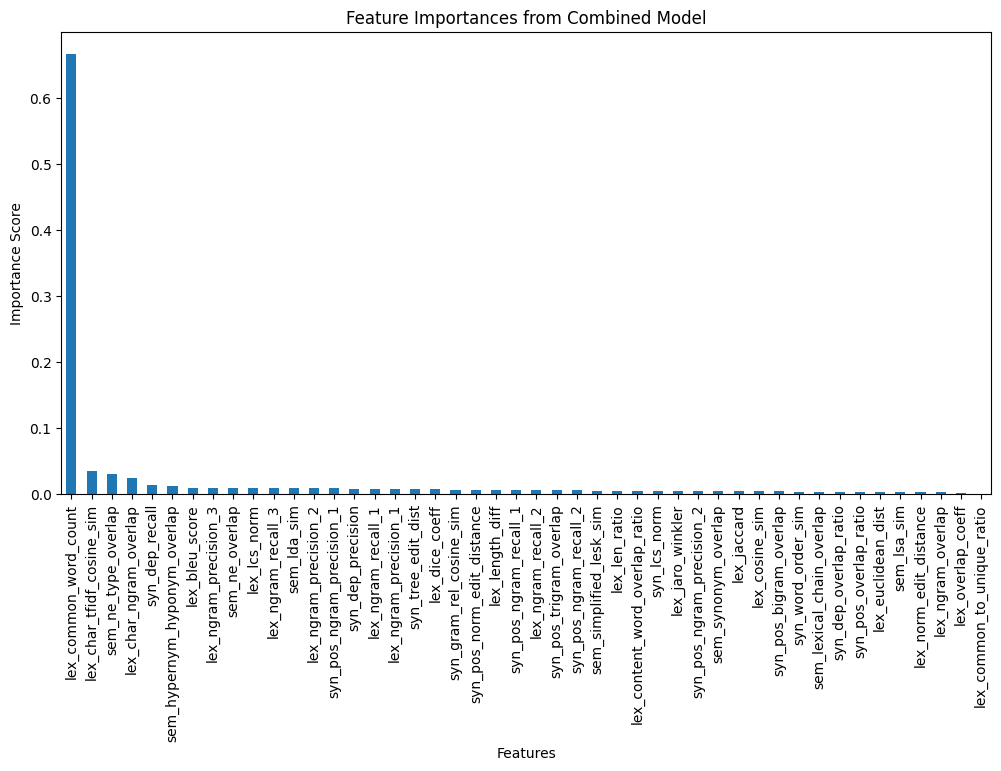

In [ ]:
import matplotlib.pyplot as plt

importance = combined_model.feature_importances_
feature_importance = pd.Series(importance, index=feature_columns)
feature_importance.sort_values(ascending=False, inplace=True)

# Display top features
print("Top 10 Features:")
print(feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(12,6))
feature_importance.plot(kind='bar')
plt.title('Feature Importances from Combined Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


### 4.2 Feature Selection
We can select the top N features to see if a reduced feature set improves or maintains performance.

In [11]:
# Select top N features
top_N = 10
top_features = feature_importance.index[:top_N]

X_train_top = X_train_combined[top_features]
X_test_top = X_test_combined[top_features]

# Retrain model with top features
top_model = train_xgboost(X_train_top, y_train)

# Predict and evaluate
y_pred_top = top_model.predict(X_test_top)
top_correlation = evaluate_model(y_test, y_pred_top)
print(f"Pearson Correlation (Top {top_N} Features): {top_correlation:.4f}")

Pearson Correlation (Top 10 Features): 0.7188


## 5. Results and Analysis

### 5.1 Pearson Correlation Scores

In [12]:
results = {
    'Model': [
        'Lexical', 
        'Syntactic', 
        'Semantic', 
        'Combined', 
        f'Top {top_N} Features'
    ],
    'Pearson Correlation': [
        lexical_correlation,
        syntactic_correlation,
        semantic_correlation,
        combined_correlation,
        top_correlation,
    ],
}

results_df = pd.DataFrame(results)
print(results_df)

             Model  Pearson Correlation
0          Lexical             0.695606
1        Syntactic             0.537271
2         Semantic             0.613920
3         Combined             0.730813
4  Top 10 Features             0.718806



**References for All Features:**

- **Word Overlap Measures (Jaccard similarity, Dice coefficient, Overlap coefficient):** Used by multiple teams in SemEval 2012 Task 6, including [Baer et al., 2012], [Glinos, 2012], and [Jimenez et al., 2012].

- **Edit Distance and String Similarity Measures:** Used by [Glinos, 2012] and [Jimenez et al., 2012].

- **TF-IDF Vector Similarity:** Employed by the UKP team [Baer et al., 2012] for computing cosine similarity using TF-IDF vectors.

- **Character N-gram Features:** Utilized by teams like [Baer et al., 2012] and [Jimenez et al., 2012].

- **BLEU Score:** Used by [Baer et al., 2012] as part of the feature set.

- **Content Word Overlap:** Considered by [Jimenez et al., 2012] in their similarity measures.

- **POS Tag Features:** Teams like [Baer et al., 2012] and [Glinos, 2012] used POS tag overlaps and distributions.

- **Dependency Relations and Tree Structures:** Explored by [Štajner et al., 2012] for syntactic similarity.

- **WordNet-based Semantic Features:** Used extensively by the UKP team [Baer et al., 2012] and the TakeLab team [Štajner et al., 2012], including synonym overlap, hypernym/hyponym overlap, and various similarity measures.

- **Named Entity Features:** Incorporated by [Baer et al., 2012].

- **Sentiment Analysis Features:** Included by teams like [Gupta et al., 2012] in their submissions.

- **Negation Handling:** Addressed by [Baer et al., 2012] to capture differences due to negation.

**Referenced Papers:**

- **[Baer et al., 2012]:**

  Baer, P., and Zesch, T. (2012). UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures. *SemEval-2012*.

- **[Štajner et al., 2012]:**

  Štajner, S., Glavaš, G., Karan, M., Šnajder, J., and Dalbelo Bašić, B. (2012). TakeLab: Systems for Measuring Semantic Text Similarity. *SemEval-2012*.

- **[Glinos, 2012]:**

  Glinos, D. (2012). ATA-Semantics: Measuring the Similarity between Sentences. *SemEval-2012*.

- **[Jimenez et al., 2012]:**

  Jimenez, S., Becerra, C., and Gelbukh, A. (2012). Soft Cardinality: A Generalization of Dice's Similarity Coefficient for Enumerated Sets. *SemEval-2012*.

- **[Gupta et al., 2012]:**

  Gupta, S., Agarwal, A., and Joshi, S. (2012). Yedi: A Hybrid Distributional and Knowledge-based Word Similarity Measure. *SemEval-2012*.

**Note:** All features utilize methods and resources available in 2012, adhering to the constraints of the SemEval 2012 Task 6.

**Usage in Feature Extraction:**